<a href="https://colab.research.google.com/github/finfrierson/data-science-fundamentals/blob/main/ReynaScoreModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "preliz[full,notebook]"
import preliz as pz
import pymc as pm
import arviz as az

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.4 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 25.5 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency con

My data is the "tracker score" of the Reyna players get in my competitive Valorant games. Valorant is a tactical first person shooter game, in which 2 teams of 5 players fight to be the first to win 13 rounds, and be winning by at least 2 rounds. I used the website tracker.gg, which gives a score called the "Tracker score" for every player in a game based off of their performance, which determines how well you are doing compared to the rest of people at your rank, where 0 is a lot worse, 500 is average, and 1000 is a lot better. Reyna is one character you can play, who's main purpose is to get as many kills as possible, so they typically have higher tracker scores. I am going to find how well you can expect a Reyna to play on average.

<Axes: >

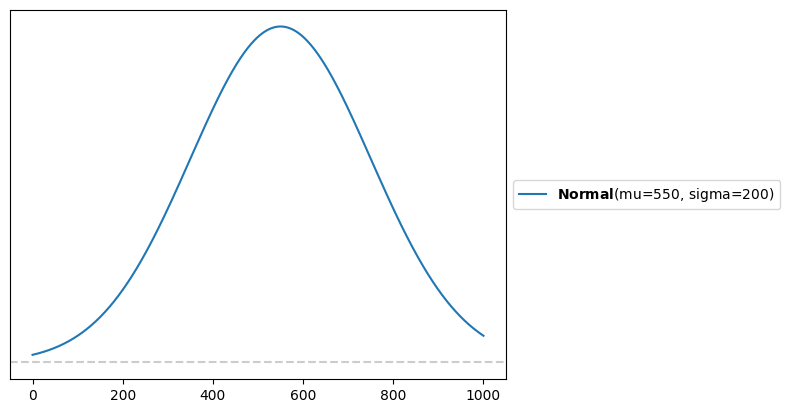

In [ ]:
#Graphing a prediction
pz.Normal(mu=550,sigma=200).plot_pdf(support=(0,1000))

Because I have played this game for a while, I can expect Reyna players to typically do above average, with a relatively large spread of scores. My prior begins at the value of 0, because that is the minimum possible score, and ranges to the max of 1000. This prior is more of my initial thoughts on how the graph would look rather than useful for a model.

My data will be collected from my own Valorant games (Last 50 games played), of both my and the enemy teams Reynas. If a game ends in under 13 rounds (Forfeit), or the Reyna player disconnects while having played under 10 rounds, I will not count their data.

In [ ]:
#Each amount of kills will be logged as a point
scores = [1000, 318, 977, 825, 689, 541, 146, 498, 645, 296, 198, 673, 681, 546, 660, 1000, 956, 349, 691, 642, 933, 106, 544, 514, 463, 679, 737, 57, 861, 647, 314, 941, 661, 481, 484, 160, 379, 550, 829, 843, 892, 899, 308, 598, 563, 545, 939, 749]
total_score=0
total_games=0
#Finding the mean Tracker Score
for score in scores:
  total_score+=score
  total_games+=1
mean = total_score/total_games
#Finding the average distance from the mean
totalvariation=0
variations=0
for score in scores:
  var = mean-score
  var = abs(var)
  totalvariation+=var
  variations+=1
variation = totalvariation/variations
mean, variation


(604.3125, 205.8828125)

Here I calculate the mean and average distance from the mean, which would be helpful for me making the model. Next is my first attempt at a model, using a StudentT distribution. For my priors I have one value always at 4, a Normal distribution based on the calculated mean and variation, and a logistic model.

In [ ]:
#Initial Student T graph, creating values and priors to put in the likelihood to make a posterior
with pm.Model() as score_model:
  μ = 4
  σ = pm.Normal('σ', mu=mean,sigma=variation)
  ν = pm.Logistic('ν', mu=200, s=25)
  y = pm.StudentT('y', nu=μ, sigma=σ,mu=ν, observed=scores)
  modeled_scores = pm.sample()

Output()

Output()

In [ ]:
#Gathering the samples
pm.sample_posterior_predictive(modeled_scores, model=score_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 1000.0)

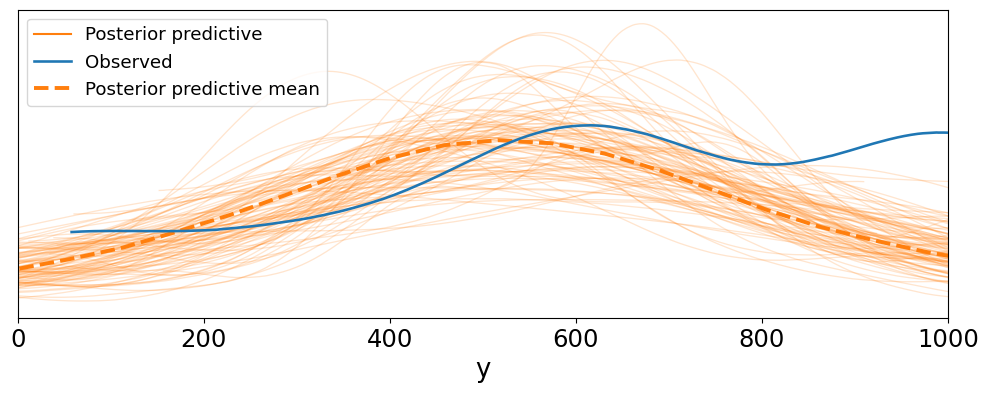

In [ ]:
#Plotting
ax = az.plot_ppc(modeled_scores, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(0, 1000)

The model for Student T tends to underestimate the scores by a good margin.

This is my most accurate model which is a SkewStudentT Distribution, where I use a Normal function, a Logistic Function, and two constants for priors.

In [ ]:
#Second, SkewStudentT, model with variables and priors created to put into the likelihood.
with pm.Model() as model2:
  σ = pm.Normal('σ', mu=mean,sigma=variation*2.5)
  ν = pm.Logistic('ν', mu=200, s=25)
  a = 3
  b = 7
  y=pm.SkewStudentT('y', a=a, b=b,sigma=σ,mu=ν, observed=scores)
  modeled_scores = pm.sample()


Output()

Output()

In [ ]:
#Gathering the samples
pm.sample_posterior_predictive(modeled_scores, model=model2, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 1000.0)

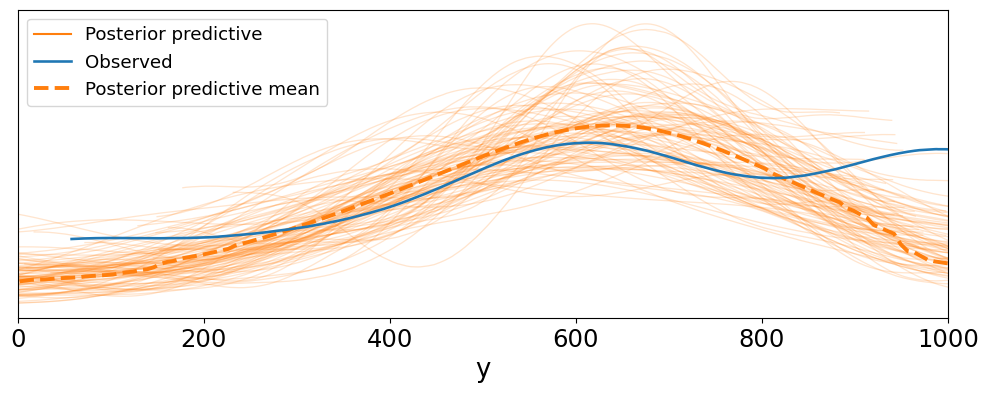

In [ ]:
#Graphing it
ax = az.plot_ppc(modeled_scores, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(0, 1000)

This model, while not capturing the second increase in volume of scores, overall has a more accurate prediction.

In conclusion, my SkewStudentT model pretty accurately models the scores of Reyna players. The model also has a more reasonable estimation for high scoring players, as my data is likely skewed from a higher number of people randomly playing really well. The data showed a peak number of scores just past 600, with equal rate of loss of volume both in the direction of higher and lower scores, but as the highest volume of scores is around 600, there is more room to lower in volume towards 0 rather than to 1000. I initially predicted a much more concentrated graph with a lower mean, which was proven otherwise by the data and model.